## Group 10 - First Year Project 
### Data Science at ITU 
## Project 2  

## This notebook contains all the code developed in the Project 2

Contact/Group: 
- Florian Micliuc(flmi@itu.dk)
- Louis Caspar Brandt (locb@itu.dk)
- Iben Mai Huse (ibhu@itu.dk)
- Katalin Literati-Dobos (klit@itu.dk)
- Ruben Jonsman (rubj@itu.dk)

## Imports

In [22]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import math
from scipy.stats import chi2_contingency
import seaborn as sns
import folium
from folium import plugins 
from folium.plugins import HeatMap, MarkerCluster
import shapely
import json 
from shapely.geometry import Point, MultiPoint, LineString, MultiLineString, Polygon, MultiPolygon
import branca
import branca.colormap as cm

# Task 0 - Data filtering and cleaning

## Loading data

In [3]:
raw_data = {}

TITLES = ['de_corona', 'weather']

Pandas has a convinient method for reading in csv files and storing the data in a DataFrame structure offers flexibility.

In [129]:
from datetime import datetime
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')

raw_data['de_corona'] = pd.read_csv("fyp_data_project2/corona/de_corona.csv", sep='\s+', parse_dates=['date'], date_parser=dateparse)
raw_data['weather'] = pd.read_csv("fyp_data_project2/weather/weather.csv", sep='\s+', parse_dates=['date'], date_parser=dateparse)

In [130]:
for TITLE in TITLES:
    print(TITLE + "\tDataFrame shape: " + str(raw_data[TITLE].shape))

de_corona	DataFrame shape: (5602, 4)
weather	DataFrame shape: (14904, 9)


 ### Data type insight

In [131]:
# Viewing the first 5 rows in the dataframe
raw_data['weather'][:5]

,date,iso3166-2,RelativeHumiditySurface,SolarRadiation,Surfacepressure,TemperatureAboveGround,Totalprecipitation,UVIndex,WindSpeed
0,2020-02-13,DE-BB,76.337444,1.824290e+06,2.403341e+06,276.551573,0.003355,2.777806,4.542822
1,2020-02-13,DE-BE,76.065297,1.786373e+06,2.408182e+06,276.844633,0.003523,4.671329,4.761509
2,2020-02-13,DE-BW,80.113988,1.505760e+06,2.290158e+06,276.227143,0.008013,4.268546,4.467024
3,2020-02-13,DE-BY,81.554346,2.363013e+06,2.275361e+06,275.583053,0.005227,4.417797,3.677414
4,2020-02-13,DE-HB,87.167414,8.389756e+03,2.406940e+06,276.237452,0.007715,1.794872,4.699573


In [132]:
raw_data['weather'][:5].shape

(5, 9)

In [133]:
raw_data['de_corona'][:5]

,date,region_code,confirmed_addition,deceased_addition
0,2020-01-02,Nordrhein-Westfalen,1,0
1,2020-01-07,Nordrhein-Westfalen,1,0
2,2020-01-09,Nordrhein-Westfalen,1,1
3,2020-01-12,Nordrhein-Westfalen,1,0
4,2020-01-14,Nordrhein-Westfalen,1,0


In [134]:
region_code = pd.Series(raw_data['de_corona']['region_code'])
region_code.unique()

array(['Nordrhein-Westfalen', 'Berlin', 'Saarland', 'Bayern',
       'Niedersachsen', 'Mecklenburg-Vorpommern', 'Brandenburg',
       'Baden-Württemberg', 'Hessen', 'Rheinland-Pfalz',
       'Schleswig-Holstein', 'Hamburg', 'Bremen', 'Sachsen', 'Thüringen',
       'Sachsen-Anhalt'], dtype=object)

## Sanity check

In [135]:
flag = False
for TITLE in TITLES:
    if raw_data[TITLE].isnull().values.any():
        for column in list(raw_data[TITLE].columns):
            nulls = sum(raw_data[TITLE][column].isnull())
            if sum(raw_data[TITLE][column].isnull()):
                print(TITLE + " - " + column + "\t has " + str(nulls) + " null values")
                flag = True
if not flag: print("There are no null values in the dataset")

There are no null values in the dataset


### Checking for null values in our sheffield dataset

## Numerical summary

### Box Plots and Five Number Summaries

In [136]:
deCorona = raw_data['de_corona']
deCorona.describe()

,confirmed_addition,deceased_addition
count,5602.000000,5602.000000
mean,426.786862,12.121028
std,831.095886,25.823844
min,1.000000,0.000000
25%,18.000000,0.000000
50%,95.000000,1.000000
75%,396.000000,10.000000
max,6809.000000,213.000000


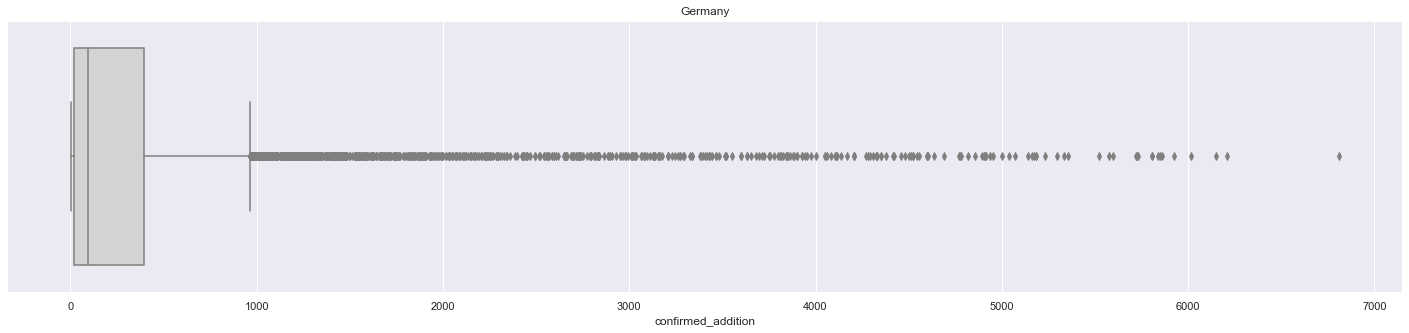

In [137]:
from matplotlib import rcParams

deCorona_confirmed = raw_data['de_corona']['confirmed_addition']
sns.boxplot(deCorona_confirmed, color='lightgray').set_title('Germany')
# figure size in inches
rcParams['figure.figsize'] = 25,2;

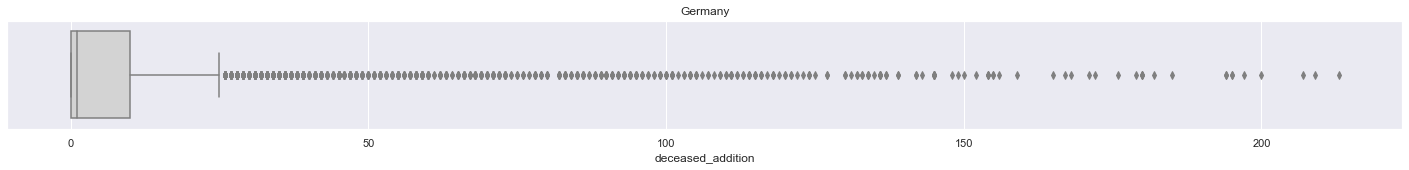

In [138]:
from matplotlib import rcParams

deCorona_deceased = raw_data['de_corona']['deceased_addition']
sns.boxplot(deCorona_deceased, color='lightgray').set_title('Germany')
# figure size in inches
rcParams['figure.figsize'] = 25,5;

In [139]:
pd.Series(raw_data['de_corona']['region_code']).unique()

array(['Nordrhein-Westfalen', 'Berlin', 'Saarland', 'Bayern',
       'Niedersachsen', 'Mecklenburg-Vorpommern', 'Brandenburg',
       'Baden-Württemberg', 'Hessen', 'Rheinland-Pfalz',
       'Schleswig-Holstein', 'Hamburg', 'Bremen', 'Sachsen', 'Thüringen',
       'Sachsen-Anhalt'], dtype=object)

In [140]:
Nordrhein_Westfalen = (raw_data['de_corona']['region_code'] == 'Nordrhein-Westfalen')
deCorona_NW_c = raw_data['de_corona']['confirmed_addition'][Nordrhein_Westfalen]
deCorona_NW_c.describe()

count     372.000000
mean     1402.010753
std      1708.670955
min         1.000000
25%       193.500000
50%       500.000000
75%      2162.250000
max      6809.000000
Name: confirmed_addition, dtype: float64

In [141]:
Nordrhein_Westfalen = (raw_data['de_corona']['region_code'] == 'Nordrhein-Westfalen')
deCorona_NW_d = raw_data['de_corona']['deceased_addition'][Nordrhein_Westfalen]
deCorona_NW_d.describe()

count    372.000000
mean      33.956989
std       48.031641
min        0.000000
25%        1.000000
50%        6.500000
75%       53.500000
max      213.000000
Name: deceased_addition, dtype: float64

In [142]:
Berlin = (raw_data['de_corona']['region_code'] == 'Berlin')
deCorona_B_c = raw_data['de_corona']['confirmed_addition'][Berlin]
deCorona_B_c.describe()

count     355.000000
mean      357.453521
std       470.304721
min         1.000000
25%        42.000000
50%       111.000000
75%       476.500000
max      1683.000000
Name: confirmed_addition, dtype: float64

In [143]:
Berlin = (raw_data['de_corona']['region_code'] == 'Berlin')
deCorona_B_d = raw_data['de_corona']['deceased_addition'][Berlin]
deCorona_B_d.describe()

count    355.000000
mean       7.684507
std       12.964169
min        0.000000
25%        0.000000
50%        1.000000
75%        9.000000
max       67.000000
Name: deceased_addition, dtype: float64

### Frequency Histogram

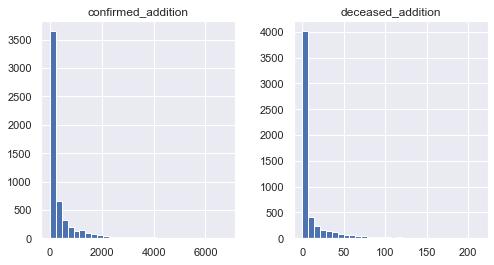

In [144]:
deCorona.hist(bins=30, figsize=(8,4))
plt.show();

### Frequency Barplot

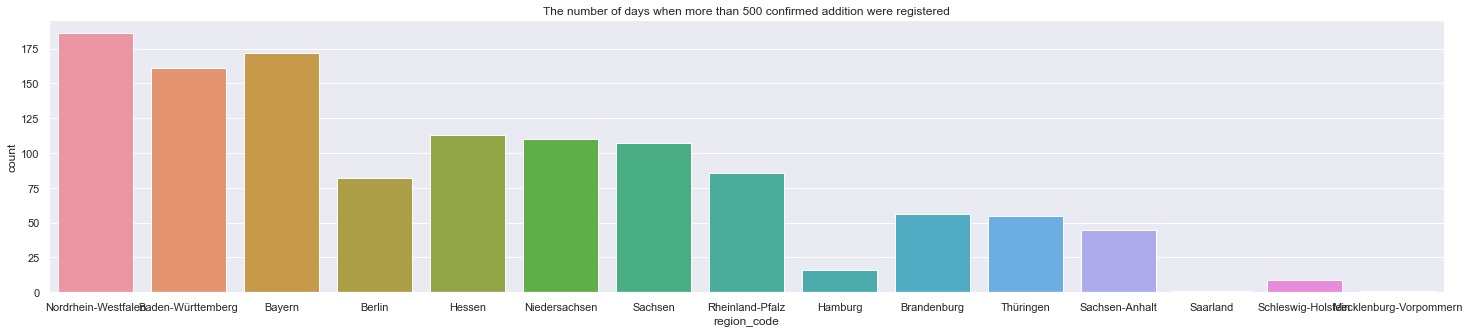

In [163]:
import seaborn as sns
sns.set(style="darkgrid")
moreThan500 = (raw_data['de_corona']['confirmed_addition']>500)
ax = sns.countplot(x="region_code", data=raw_data['de_corona'][moreThan500]).set_title('The number of days when more than 500 confirmed addition were registered')

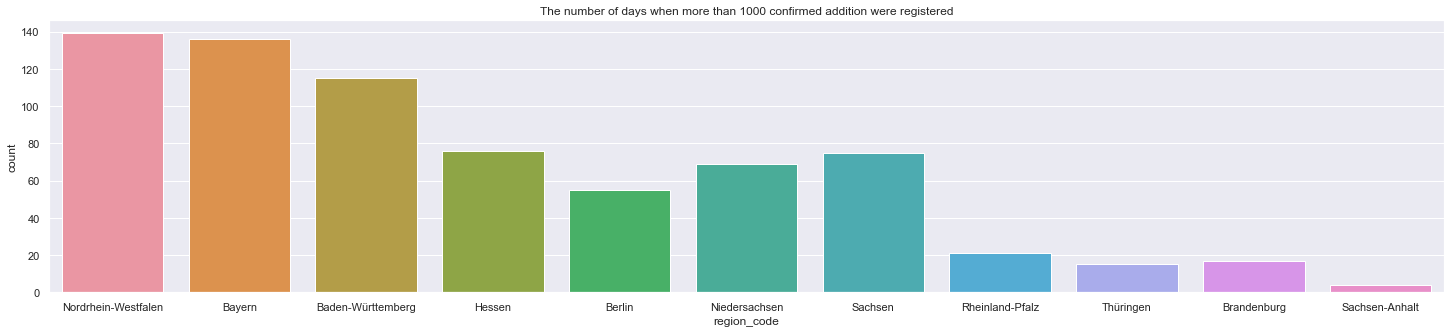

In [164]:
import seaborn as sns
sns.set(style="darkgrid")
moreThan1000 = (raw_data['de_corona']['confirmed_addition']>1000)
ax = sns.countplot(x="region_code", data=raw_data['de_corona'][moreThan1000]).set_title('The number of days when more than 1000 confirmed addition were registered')

In [152]:
raw_data['de_corona'].reset_index(inplace=True)
#df.columns = ['Date','sum']
raw_data['de_corona'].head()
raw_data['de_corona']['month'] = raw_data['de_corona']['date'].dt.strftime('%b')
raw_data['de_corona']['month']

0       Jan
1       Jan
2       Jan
3       Jan
4       Jan
       ... 
5597    Feb
5598    Feb
5599    Feb
5600    Feb
5601    Feb
Name: month, Length: 5602, dtype: object

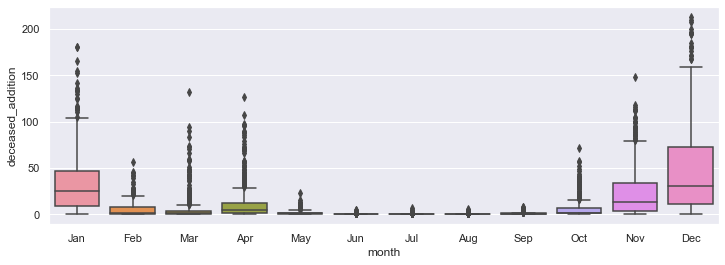

In [154]:
fig, ax = plt.subplots()
fig.set_size_inches((12,4))
sns.boxplot(x='month',y='deceased_addition',data=raw_data['de_corona'],ax=ax).set_title()
plt.show()

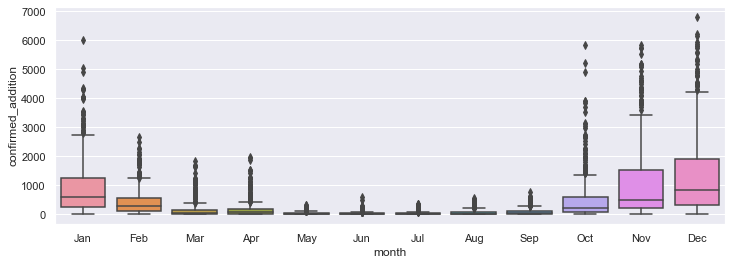

In [156]:
fig, ax = plt.subplots()
fig.set_size_inches((12,4))
sns.boxplot(x='month',y='confirmed_addition',data=raw_data['de_corona'],ax=ax)
plt.show()

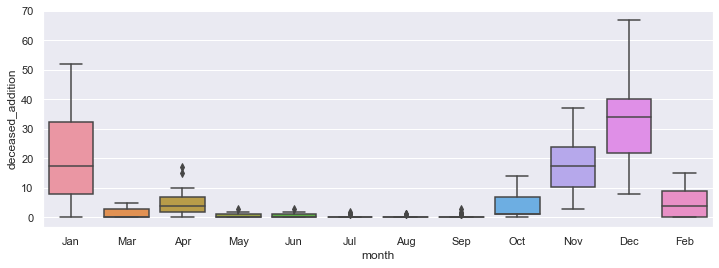

In [158]:
fig, ax = plt.subplots()
fig.set_size_inches((12,4))
sns.boxplot(x='month',y='deceased_addition',data=raw_data['de_corona'][Berlin],ax=ax)
plt.show()

# Task 1 - Single variable analysis

# Task 2 - Associations

# Task 3 - Map visualization

# Task 4: Open question